## Plot TINATs Peak Coverage

In [4]:
# %%R 
suppressMessages(suppressWarnings(library (RADAR)))
# suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (tidyverse)))

`radar` conda env

In [5]:
res = read.table('radar_herv/line/result.sig.txt',header=TRUE)
res %>% head

,chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
,<fct>,<int>,<int>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,chr13,113845719,113845768,1011168:LINE:L1ME4b_3end,0,+,113845719,113845768,0,1,50,0,5.313206,8.461970e-04
2,chr13,114315605,114315654,1011370:LINE:L1MB8_3end,0,+,114315605,114315654,0,1,50,0,5.241747,9.634334e-04
3,chr14,19061114,19061163,1011737:LINE:L1P1_orf2,0,+,19061114,19061163,0,1,50,0,20.273000,3.865957e-03
4,chr1,155468145,155468194,103841:LINE:L1MD3_3end,0,-,155468145,155468194,0,1,50,0,6.461468,3.378580e-08
5,chr14,75003707,75003756,1049006:LINE:L1M5_orf2,0,+,75003707,75003756,0,1,50,0,3.850148,6.111667e-04
6,chr14,97240300,97240349,1065433:LINE:L1M5_orf2,0,+,97240300,97240349,0,1,50,0,2.423538,1.735992e-03


In [7]:
# %%R
radar0 <- readRDS('radar_herv/line/finalObj.rds')

In [8]:
# %%R
radar <- PrepCoveragePlot(
    radar0
    # ,gtf='../../scallop-genome/DAC_GRCh37_merged.gtf'
)

In [9]:
# %%R 
summary(radar)

MeRIP.RADAR dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
        U1   U2   T1   T2
Input 0.77 0.93 0.85 0.81
IP    0.65 0.60 0.78 0.84
Input gene level read count available.
There are 1 predictor variables/covariates. Can access by function variable(MeRIPdata). 
Differential methylation tested by PoissonGamma test (RADAR).
Multiple test corrected by Benjamini & Hochberg.


### `1011737:LINE:L1P1_orf2`

In [25]:
name_it = '103841:LINE:L1MD3_3end'
makeGRangesFromDataFrame(res[res$name == name_it,])

GRanges object with 1 range and 0 metadata columns:
    seqnames              ranges strand
       <Rle>           <IRanges>  <Rle>
  4     chr1 155468145-155468194      -
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [31]:
ZoomIn_peak = c(155468145-100,155468194)
geneName <- name_it
chr <- "chr1"
title <- name_it
ymax <- 500

gr = radar@GTF[seqnames(radar@GTF) == chr & radar@GTF$type == 'gene' & radar@GTF$gene_id == geneName]
ZoomIn_gene = c(start (gr),end (gr))

In [32]:
gr

GRanges object with 0 ranges and 6 metadata columns:
   seqnames    ranges strand |   source     type     score     phase
      <Rle> <IRanges>  <Rle> | <factor> <factor> <numeric> <integer>
       gene_id transcript_id
   <character>   <character>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [33]:
p_peak <- plotGeneCov(
    radar,geneName = geneName,
    center = mean, libraryType = "opposite",
    ZoomIn = c(
        ZoomIn_peak[1],
        ZoomIn_peak[2]
    ), adjustExprLevel = F
    , split = F
) + theme_classic() +
# theme_void() + 
theme(
    # legend.position = "none",    
    axis.text.x = element_text(angle = 30, vjust = 1,hjust=1)
) + ggtitle(title)

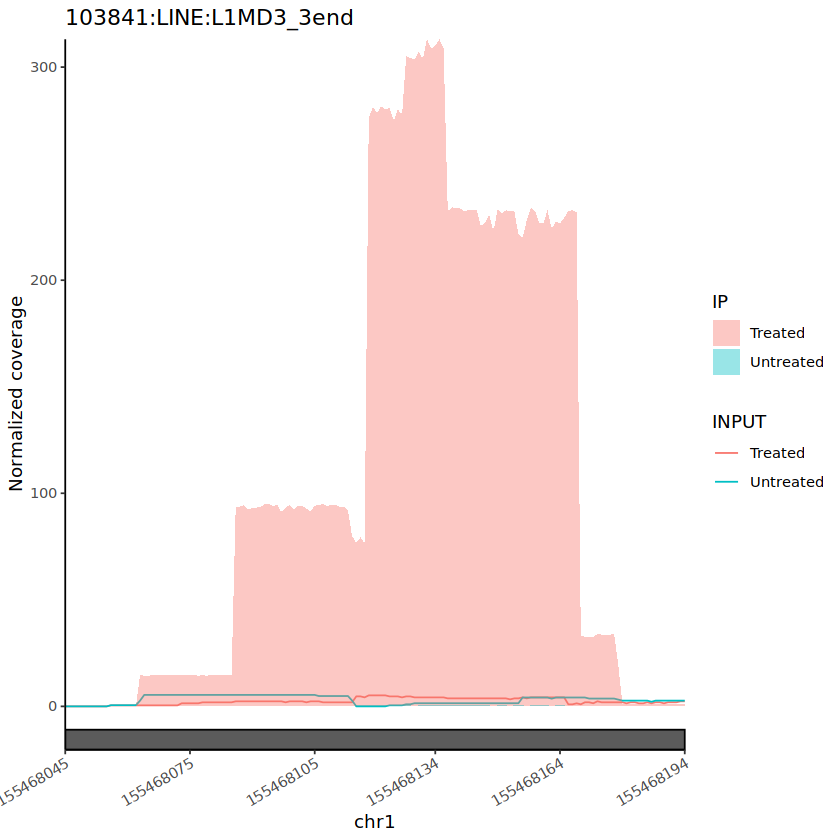

In [34]:
p_peak

In [39]:
# p_gene <- plotGeneCov(
#     radar,geneName = name_it,
#     center = mean, 
#     libraryType = "opposite",
#     ZoomIn = ZoomIn_gene, adjustExprLevel = T
#     #, split = T
# ) + theme_classic() + theme(
#     axis.text.x = element_text(angle = 30, vjust = 1,hjust=1)
# ) + geom_vline(
#     xintercept = ZoomIn_peak[1], colour="lightgrey", linetype = "longdash"
# ) + geom_vline(
#     xintercept = ZoomIn_peak[2] - 1000, colour="lightgrey", linetype = "longdash"
# ) + ylim(0,ymax) 

In [40]:
# %%R 
# p_peak / p_gene

In [41]:
# %%R 
# ggsave(paste0('plots/coverage_',title,'.eps'),p_peak / p_gene,width=10,height=5,dpi=600,device=cairo_ps)

In [58]:
ggsave(
    paste0('plots/coverage_',title,'.eps'),
    p_peak,
    width=10,height=5,dpi=600,device=cairo_ps
)

### 

In [44]:
date()


[1] "Mon Sep  4 22:56:28 2023"

## Plot annotation track

- https://www.biostars.org/p/184091

`gviz` conda env

In [ ]:
suppressMessages(suppressWarnings(library (Gviz)))
suppressMessages(suppressWarnings(library (GenomicRanges)))
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tidyverse)))

In [ ]:
GTF ='../scallop-genome/DAC_GRCh37_merged.gtf'

gtf  = rtracklayer::import(GTF)
txdb = GenomicFeatures::makeTxDbFromGFF(GTF,organism='Homo sapiens')

In [ ]:
plot_gene_tracks <- function(txdb, gene_id, title, ZoomIn_peak, gen='hg38',wide=0,save=NULL){
    gn <- genes(txdb)[genes(txdb)$gene_id == gene_id]
    
    Start <- gn %>% start
    End   <- gn %>% end

    gr <- exonsBy(txdb, by = "gene")[c(gene_id)]
    gr <- unlist(gr)

    elementMetadata(gr)$transcript <- names(gr)

    gtrack  <- GenomeAxisTrack()
    itrack  <- IdeogramTrack(genome = gen, chromosome = seqnames(gn) %>% as.character, col="lightgrey",fill="orangered")
    grtrack <- Gviz::GeneRegionTrack(
        gr, 
        start = Start, end = End,
        name="",
        background.panel = NA, 
        background.title = NA
    )
    
    ht <- HighlightTrack(
        trackList = list(gtrack,grtrack),
        start = ZoomIn_peak[1] - wide, end = ZoomIn_peak[2] + wide,
        chromosome = seqnames(gn) %>% as.character,
        inBackground=FALSE,
        col="lightgrey",fill="lightgrey" #"orangered"
    )
    l = list (ht, itrack)
    s = c (3,1,1)
    if (!is.null(save)){
        pdf(save,width=10, height=2)
        Gviz::plotTracks(l,from = Start, to = End, main = title, sizes=s)
        dev.off()
    } else {
        Gviz::plotTracks(l,from = Start, to = End, main = title, sizes=s)
    }
}

In [ ]:
res[res$name == 'DAC.12-x1-0',]

In [ ]:
p <- plot_gene_tracks(
    txdb, 
    'DAC.12-x1-0',
    'DAC.12-x1-0',
    ZoomIn_peak = c(85724299,85724348)
    ,wide = 300
    # ,save = 'plots/tracks_BCL2.pdf'
)

# ZoomIn_peak = c()
# geneName <- ''
# chr <- "chr1"
# title <- 'DAC.12-x1-0'


In [ ]:
sessionInfo()

## Extract Peak Sequence 

In [ ]:
import pandas as pd 

In [ ]:
def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

In [ ]:
def remove_intron(bed, fa):
    '''
    Remove introns for genes in given bed12 file 
    with blockSizes greater than 1
    '''
    # fa = read_fasta(fa)
    # bed = pd.read_table(bed, header=0)
    tochange = bed[bed.blockCount > 1]
    starts = [tochange.blockStarts[i].split(',')[:tochange.blockCount[i]] for i in tochange.index.tolist() ]
    sizes = [tochange.blockSizes[i].split(',')[:tochange.blockCount[i]] for i in tochange.index.tolist() ]
    for id, x, l in zip(tochange.name.tolist(), starts, sizes):
        fa[id] = ''.join([fa[id][int(i):int(i)+int(j)] for i,j in zip(x,l)])
    return fa


In [ ]:
def search_fasta(fa1,fa2):
    return dict(
        [((x,fa1[x]),(y,fa2[y])) for x in fa1 for y in fa2 if fa1[x] in fa2[y] ]
    )
        

In [ ]:
!zcat ~/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa.gz \
> ~/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa

In [ ]:
!which samtools

In [ ]:
!samtools faidx ~/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa

In [ ]:
!which bedtools

In [ ]:
%%bash 
bedtools getfasta -name -s -fi \
~/genomes/hg38/gencode.v34/GRCh38.primary_assembly.genome.fa \
-bed target-genes-sig-peaks.bed -split -fo target-genes-sig-peaks.fa

In [ ]:
!cat target-genes-sig-peaks.fa

In [ ]:
# target_fa = read_fasta('target-genes.fa')
target_fa = read_fasta('target-genes-sig-peaks.fa')

# target_fa = dict([(key.split('::')[0]+'_peak'+str(i),target_fa[key]) for i,key in enumerate(target_fa)])

In [ ]:
target_fa

In [ ]:
genome_fa = read_fasta(
    '/data_gilbert/home/aarab/genomes/hg38/gencode.v34/gencode.v34.transcripts.fa'
)

In [ ]:
o = search_fasta(target_fa,genome_fa)

In [ ]:
target_id2name = {
    "ENSG00000185085.2":"INTS5",
    "ENSG00000132382.14":"MYBBP1A",
    "ENSG00000104549.12":"SQLE",
    "ENSG00000171791.13":"BCL2"
}

In [ ]:
transcripts = dict(list({(
    # target_id2name[o[peak][0].split('|')[1]], o[peak][1]
    o[peak][0], o[peak][1]
) for peak in o.keys()}))

In [ ]:
{(k,transcripts[k]) for k in transcripts if 'BCL2' in k}

In [ ]:
bed = pd.read_table('target-genes-sig-peaks.bed', header=0)

[
    remove_intron(
        bed[bed.iloc[:,1] == int(peak.split('::')[1].split(':')[1].split('-')[0])],
        {peak.split('::')[0]: target_fa[peak]}
    )
    for peak in target_fa
]